In [1]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from tensorflow.keras import layers, Model


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Langkah-langkah untuk Membangun Sistem Rekomendasi Resep dengan Jaringan Siamese
Notebook ini bertujuan untuk membuat sistem rekomendasi resep menggunakan pendekatan jaringan Siamese. Berikut adalah tahapan-tahapan yang akan kita lakukan dalam proses ini:

- Memuat dan Memproses Dataset: Menggabungkan kolom-kolom penting seperti kategori, judul, dan bahan untuk menjadi satu teks yang nantinya akan diproses oleh model BERT.

- Membuat Embedding BERT: Menggunakan model BERT yang sudah dilatih sebelumnya untuk menghasilkan embedding dari setiap resep, yang akan merepresentasikan setiap resep dalam bentuk vektor.

- Membuat Pasangan Positif dan Negatif: Berdasarkan kategori, kita membuat pasangan positif (kategori sama) dan negatif (kategori berbeda) sebagai data latih untuk model.

- Mendefinisikan dan Melatih Jaringan Siamese: Membangun dan melatih jaringan Siamese dengan menggunakan pasangan positif dan negatif. Model ini dilatih menggunakan contrastive loss untuk mengoptimalkan jarak antara resep yang mirip dan yang tidak mirip.

- Menyimpan Model dan Embedding: Setelah pelatihan selesai, kita simpan model dan embedding resep sehingga bisa digunakan lagi tanpa harus melatih model atau menghitung ulang embedding setiap kali.

Setelah proses selesai, sistem ini dapat memberikan rekomendasi resep yang mirip berdasarkan resep-resep yang sudah disimpan.

In [2]:
recipes_df = pd.read_csv('full_format_recipes.csv')

Pertama-tama, kita muat dataset dan menggabungkan beberapa kolom seperti categories, title, dan ingredients menjadi satu teks. Ini membantu kita membuat representasi teks yang lebih lengkap untuk setiap resep, sehingga BERT bisa menghasilkan embedding yang lebih baik.



In [3]:
def preprocess_text(row):
    categories = ' '.join(eval(row['categories'])) if pd.notnull(row['categories']) else ''
    title = row['title'] if pd.notnull(row['title']) else ''
    ingredients = ' '.join(eval(row['ingredients'])) if pd.notnull(row['ingredients']) else ''
    return f"{categories}. {title}. {ingredients}"

recipes_df['bert_input_text'] = recipes_df.apply(preprocess_text, axis=1)
texts = recipes_df['bert_input_text'].tolist()

## Membuat Embedding BERT
Setelah teks untuk setiap resep siap, kita menggunakan model BERT untuk menghasilkan embedding. Embedding ini akan digunakan sebagai dasar untuk melatih jaringan siamese, yang akan belajar mengenali kemiripan antar resep.

In [4]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
bert_embeddings = []
for text in texts:
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True)
    outputs = bert_model(inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  
    bert_embeddings.append(cls_embedding.numpy().flatten()) 

bert_embeddings = np.array(bert_embeddings)

In [18]:
recipes_df['embedding'] = list(bert_embeddings)
embeddings = recipes_df['embedding']
embeddings = np.array(list(recipes_df['embedding'])).reshape(-1, 768, 1)


## Membuat Pasangan Positif dan Negatif
Pada tahap ini, kita membuat pasangan positif dan negatif. Pasangan positif berisi resep-resep yang memiliki kategori serupa, sementara pasangan negatif memiliki kategori yang berbeda. Dengan pasangan-pasangan ini, model bisa belajar membedakan antara resep yang mirip dan tidak mirip.



In [19]:
def common_category(categories1, categories2):
    set1 = set(eval(categories1)) if isinstance(categories1, str) else set(categories1)
    set2 = set(eval(categories2)) if isinstance(categories2, str) else set(categories2)
    return len(set1.intersection(set2)) > 0

def generate_pairs(recipes_df, embeddings, num_pairs=1000):
    positive_pairs, negative_pairs = [], []
    
    for _ in range(num_pairs):
        idx1 = np.random.randint(len(recipes_df))
        
        positive_candidates = [idx for idx in recipes_df.index if idx != idx1 and common_category(
            recipes_df.iloc[idx1]['categories'], recipes_df.iloc[idx]['categories'])]
        
        if positive_candidates:
            idx2 = np.random.choice(positive_candidates)
            positive_pairs.append([embeddings[idx1], embeddings[idx2]])

        negative_candidates = [idx for idx in recipes_df.index if idx != idx1 and not common_category(
            recipes_df.iloc[idx1]['categories'], recipes_df.iloc[idx]['categories'])]
        
        if negative_candidates:
            idx3 = np.random.choice(negative_candidates)
            negative_pairs.append([embeddings[idx1], embeddings[idx3]])

    return np.array(positive_pairs), np.array(negative_pairs)

positive_pairs, negative_pairs = generate_pairs(recipes_df, embeddings)



## Mendefinisikan dan Melatih Model Jaringan Siamese
Di bagian ini, kita membangun jaringan Siamese. Jaringan ini memiliki arsitektur berbagi bobot (shared network), yang berarti kedua input resep (dalam pasangan positif atau negatif) akan diproses melalui jaringan yang sama. Model ini dilatih dengan menggunakan contrastive loss sehingga embedding dari resep yang mirip akan lebih dekat, sedangkan yang tidak mirip akan semakin berjauhan.

In [ ]:

def contrastive_loss(y_true, y_pred, margin=1.0):
    positive_loss = y_true * tf.square(y_pred)
    negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(positive_loss + negative_loss)

input_shape = (768,)  
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

shared_network = tf.keras.Sequential([
    layers.InputLayer(shape=(768,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu')
])
processed_a = shared_network(input_a)
processed_b = shared_network(input_b)
distance = layers.Lambda(lambda embeddings: tf.norm(embeddings[0] - embeddings[1], axis=1, keepdims=True))([processed_a, processed_b])
siamese_model = Model(inputs=[input_a, input_b], outputs=distance)
siamese_model.compile(optimizer='adam', loss=contrastive_loss)


In [28]:
siamese_model.fit([positive_pairs[:, 0], positive_pairs[:, 1]], np.ones(len(positive_pairs)),
                  epochs=100, batch_size=32)

siamese_model.fit([negative_pairs[:, 0], negative_pairs[:, 1]], np.zeros(len(negative_pairs)),
                  epochs=100, batch_size=32)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00  
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Ep

## Menggunakan Model untuk Rekomendasi Resep
Bagian terakhir adalah menggunakan model yang sudah kita simpan serta dataset dengan embedding untuk merekomendasikan resep yang mirip. Rekomendasi ini berdasarkan pada rata-rata embedding dari beberapa resep yang disukai pengguna. Sistem akan menghitung kesamaan kosinus antara embedding rata-rata ini dengan semua embedding resep lainnya, lalu memberikan rekomendasi yang paling mirip.

In [29]:

embeddings = np.array([np.array(emb) for emb in embeddings])
def recommend_similar(liked_recipe_indices, top_n=5):
    liked_embeddings = [
        shared_network.predict(tf.convert_to_tensor(embeddings[idx].reshape(1, -1), dtype=tf.float32)) 
        for idx in liked_recipe_indices
    ]
    average_embedding = np.mean(np.array(liked_embeddings), axis=0)  

    all_embeddings_tensor = tf.convert_to_tensor(embeddings, dtype=tf.float32)
    all_embeddings = shared_network.predict(all_embeddings_tensor)

    similarities = cosine_similarity(average_embedding, all_embeddings)[0]

    similar_indices = similarities.argsort()[-top_n:][::-1]

    print("Liked Recipes:")
    liked_recipes = recipes_df.iloc[liked_recipe_indices]
    print(liked_recipes[['title', 'categories', 'ingredients']])
    print("\nRecommended Recipes:")
    
    recommended_recipes = recipes_df.iloc[similar_indices]
    return recommended_recipes[['title', 'categories', 'ingredients']]

liked_recipe_indices = [7, 20, 50]  
recommended_recipes = recommend_similar(liked_recipe_indices, top_n=5)
print(recommended_recipes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
Liked Recipes:
                                                title  \
7                          Raw Cream of Spinach Soup    
20  Baked Halibut with Orzo, Spinach, and Cherry T...   
50                       Honey-Ginger Barbecue Sauce    

                                           categories  \
7   ['Soup/Stew', 'Garlic', 'Onion', 'No-Cook', 'V...   
20  ['Fish', 'Leafy Green', 'Pasta', 'Tomato', 'Ba...   
50  ['Sauce', 'Garlic', 'Ginger', 'Side', 'Fourth ...   

                                          ingredients  
7   ['2 cups fresh tomato and/or carrot juice (fro...  
20  ['4 tablespoons extra-virgin olive oil, divide...  
50  ['1 1/2 cups apple cider vinegar', '1/2 cup mi...  

Recommended Recipes:
                                                  title  \
8474           Snapper on Angel Hair with Citrus Cream    
2829  

## Menyimpan Model dan Embedding
Setelah selesai melatih model, kita simpan model yang sudah terlatih dan embedding yang telah dihasilkan. Dengan begitu, kita dapat menggunakan model ini untuk rekomendasi tanpa harus menghitung ulang embedding atau melatih ulang model setiap kali.

In [30]:
siamese_model.save("siamese_model.h5")

In [31]:
siamese_model.save("siamese_model.keras")

In [17]:

recipes_df.to_csv("recipes_with_final_embeddings.csv", index=False)


In [32]:
np.savez("pairs_data.npz", positive_pairs=positive_pairs, negative_pairs=negative_pairs)


In [2]:
loaded_data = np.load("pairs_data.npz")
positive_pairs = loaded_data['positive_pairs']
negative_pairs = loaded_data['negative_pairs']


In [3]:
print("Positive pairs sample:", positive_pairs[:5])
print("Negative pairs sample:", negative_pairs[:5])


Positive pairs sample: [[[-0.6078007  -0.07980317  0.15885085 ... -0.6041009  -0.01867354
   -0.05465975]
  [-0.5305482   0.0079276   0.25679785 ... -0.34067935 -0.18292426
    0.1145921 ]]

 [[-0.86316055 -0.24902688 -0.07433879 ... -0.4272893  -0.03546474
    0.1319158 ]
  [-0.35879922 -0.14659628  0.11589353 ... -0.32180303  0.21584162
   -0.2944765 ]]

 [[-0.4988777  -0.29243356  0.27694336 ... -0.43499902  0.04806218
    0.04982314]
  [-0.8476791  -0.35935372  0.11118697 ... -0.3934528  -0.21694234
    0.10641096]]

 [[-0.8686137  -0.12373882  0.00626815 ... -0.05601612 -0.28090456
    0.05454259]
  [-0.8079493  -0.36698288  0.22198065 ... -0.57379925 -0.09493252
   -0.01930321]]

 [[-0.80910116  0.09506887  0.07746088 ... -0.3592273  -0.14338455
    0.16028799]
  [-0.6116055  -0.18038167  0.2973811  ... -0.64124274 -0.15812072
    0.00676766]]]
Negative pairs sample: [[[-6.0780072e-01 -7.9803169e-02  1.5885085e-01 ... -6.0410088e-01
   -1.8673539e-02 -5.4659747e-02]
  [-7.5986558

In [4]:
# Calculate distances between embeddings in positive pairs
pos_distances = [np.linalg.norm(pair[0] - pair[1]) for pair in positive_pairs]
neg_distances = [np.linalg.norm(pair[0] - pair[1]) for pair in negative_pairs]

print("Average distance for positive pairs:", np.mean(pos_distances))
print("Average distance for negative pairs:", np.mean(neg_distances))


Average distance for positive pairs: 6.86966
Average distance for negative pairs: 7.2921066


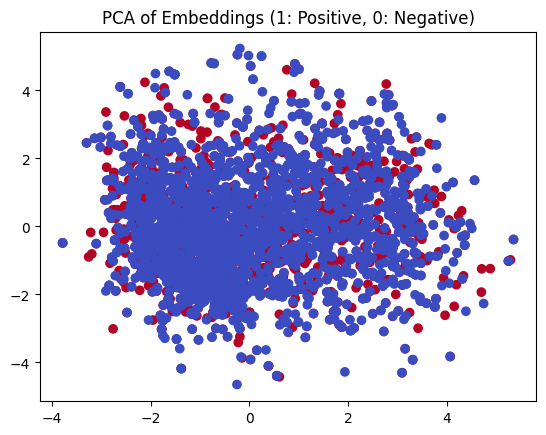

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate positive and negative pairs for visualization
all_embeddings = np.concatenate([positive_pairs[:, 0], positive_pairs[:, 1], negative_pairs[:, 0], negative_pairs[:, 1]])
labels = np.array([1] * len(positive_pairs) * 2 + [0] * len(negative_pairs) * 2)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='coolwarm')
plt.title("PCA of Embeddings (1: Positive, 0: Negative)")
plt.show()
